<a href="https://colab.research.google.com/github/JoseVillagranE/IBGAN/blob/master/IBGAN_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import Parameter, init
from torch.nn.utils import spectral_norm
from torch.distributions.multivariate_normal import MultivariateNormal
from itertools import chain

class UnFlatten(nn.Module):
    
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size

    def forward(self, x):
        return x.view(x.size(0), -1, self.block_size, self.block_size)
        
class Flatten(nn.Module):
    
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x.view(x.size(0), -1)

class IBGAN(nn.Module):
    
    
    def __init__(self, ngf, ndf, z_dim, r_dim, lr_G, lr_D, lr_Q, lr_E, nc=3):
        
        super().__init__()
        
        self.r_dim = r_dim
        
        # Block programing with respect of paper
        
        self.Block_E = nn.Sequential(nn.Linear(z_dim, ngf*2), nn.BatchNorm1d(ngf*2), nn.ReLU(),
                                     nn.Linear(ngf*2, ngf), nn.BatchNorm1d(ngf), nn.ReLU(),
                                     nn.Linear(ngf, r_dim*2))
        
        self.Block_G = nn.Sequential(nn.Linear(r_dim, ngf*16), nn.BatchNorm1d(ngf*16), nn.ReLU(),
                                     nn.Linear(ngf*16, 16*4*ngf), nn.BatchNorm1d(16*4*ngf), nn.ReLU(),
                                     UnFlatten(4),
                                     #nn.Conv2d(ngf*4, ngf*4, 3), nn.BatchNorm2d(ngf*4), nn.ReLU(),
                                     #nn.Conv2d(ngf*4, ngf*4, 3), nn.BatchNorm2d(ngf*4), nn.ReLU(),
                                     nn.ConvTranspose2d(ngf*4, ngf*4, 4, 2, 1), nn.BatchNorm2d(ngf*4), nn.ReLU(),
                                     nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1), nn.BatchNorm2d(ngf*2), nn.ReLU(),
                                     nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1), nn.BatchNorm2d(ngf), nn.ReLU(),
                                     nn.ConvTranspose2d(ngf, nc, 4, 2, 1), nn.Tanh())
        
        self.SubBlock_QD = nn.Sequential(nn.Conv2d(nc, ndf, 4, 2, 1), nn.ReLU(),
                                         nn.Conv2d(ndf, ndf*2, 4, 2, 1), nn.BatchNorm2d(ndf*2), nn.ReLU(),
                                         nn.Conv2d(ndf*2, ndf*4, 4, 2, 1), nn.BatchNorm2d(ndf*4), nn.ReLU(),
                                         spectral_norm(nn.Conv2d(ndf*4, ndf*8, 4, 2, 1)), nn.BatchNorm2d(8*ndf), nn.ReLU(),
                                         )
       
        self.Block_Q = nn.Sequential(Flatten(),
                                     nn.Linear(ndf*16*8, ndf*16), nn.BatchNorm1d(ndf*16), nn.ReLU(),
                                     nn.Linear(ndf*16, z_dim))
        
        self.Block_D = spectral_norm(nn.Conv2d(ndf*8, 1, 4, 1, 0))
        
        self.OptD = optim.RMSprop(chain(self.Block_D.parameters(), self.SubBlock_QD.parameters()), 
                                  lr=lr_D, momentum=0.9)
        self.OptG = optim.RMSprop(self.Block_G.parameters(), lr=lr_G, momentum=0.9)
        self.OptE = optim.RMSprop(self.Block_E.parameters(), lr=lr_E, momentum=0.9)
        self.OptQ = optim.RMSprop(chain(self.Block_Q.parameters(), self.SubBlock_QD.parameters()), 
                                  lr=lr_Q, momentum=0.9)
        
    def r_sampler(self, x):
        r = self.Block_E(x)
        mu = r[:, :self.r_dim]
        var = F.softplus(r[:, self.r_dim:]) + 1e-5
        scale_tri = torch.diag_embed(var)
        return MultivariateNormal(loc=mu, scale_tril=scale_tri)
    
    def generate(self, x):
        g = self.Block_G(x)
        return g
        
    def discriminate(self, x):
        x = self.SubBlock_QD(x)
        d = self.Block_D(x)
        return d.view(-1)
        
    def forward(self, x):
        
        x = self.SubBlock_QD(x)
        Q = self.Block_Q(x)
        D = self.Block_D(x)
        return D.view(-1), Q

In [2]:
from torch.distributions.kl import kl_divergence
import torchvision.datasets as Dataset

import tqdm
from itertools import chain
from os.path import join as pjoin
import numpy as np

from torchvision import transforms
import torch.utils.data as data
import torchvision.utils as vutils

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
def InfiniteSampler(n):
    # i = 0
    i = n - 1
    order = np.random.permutation(n)
    while True:
        yield order[i]
        i += 1
        if i >= n:
            np.random.seed()
            order = np.random.permutation(n)
            i = 0


class InfiniteSamplerWrapper(data.sampler.Sampler):
    def __init__(self, data_source):
        self.num_samples = len(data_source)

    def __iter__(self):
        return iter(InfiniteSampler(self.num_samples))

    def __len__(self):
        return 2 ** 31


def trans_maker(size=256):
	trans = transforms.Compose([transforms.Resize((size)),
					transforms.CenterCrop((size)), 
					transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5)),
					#_rescale
					])
	return trans

def KL_Loss(z):
	mu = z.mean()
	logvar = z.var().log()
	return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())




In [7]:
import zipfile
with zipfile.ZipFile('drive/My Drive/img_align_celeba.zip', 'r') as zip_ref:
    zip_ref.extractall('./celeba')

In [17]:
path_to_dataset = './drive/My Drive/dataset'
celeba_id = '0B7EVK8r0v71pZjFTYXZWM3FlRnM'

In [36]:
import requests

def download_file_from_google_drive(id, destination):
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value

        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 32768

        with open(destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)

    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)

destination = '../celeba'
download_file_from_google_drive(celeba_id, destination)

In [15]:
def train(Model, args_dict):
    print("-------- training --------")
    dataset = Dataset.ImageFolder(root=args_dict['DATA_ROOT'], transform=trans_maker(64)) 
    subdataset = Subset(dataset, list(range(0, args_dict['NUM_IMG'])))
    dataloader = iter(DataLoader(subdataset, args_dict['BATCH_SIZE'], sampler=InfiniteSamplerWrapper(subdataset), num_workers=0, pin_memory=True))
    
    #dataset = Dataset.CelebA(root=args_dict["DATA_ROOT"], split=".", transform=trans_maker(64), download=True)
    #dataset = torch.load(path_to_dataset)
    #dataloader = DataLoader(dataset, args_dict['BATCH_SIZE'])
    
    loss_bce = nn.BCELoss()
    loss_mse = nn.MSELoss()
    
    M_r = MultivariateNormal(loc=torch.zeros(args_dict['R_DIM']).to(args_dict['device']), 
    scale_tril=torch.ones(args_dict['R_DIM'], args_dict['R_DIM']).to(args_dict['device']))
    
    D_real = D_fake = D_z_kl = G_real = Z_recon = R_kl = 0
    fixed_z = torch.randn(64, args_dict['Z_DIM']).to(args_dict['device'])
    
    LOG_INTERVAL = args_dict['LOG_INTERVAL']
    
    z = torch.randn(100, args_dict['R_DIM'], device=args_dict['device'])
    fixed_noise = z
    D_loss = []
    R_loss =[]
    # for n_iter in tqdm.tqdm(range(0, args_dict['ITERATIONS'])):
    
    for epoch in range(args_dict['ITERATIONS']):
        for n_iter, (X, _) in enumerate(dataloader):
            # real_image = next(dataloader)[0].to(args_dict['device'])
            real_image = Variable(X).to(args_dict['device'])
            z = torch.randn(args_dict['BATCH_SIZE'], args_dict['Z_DIM']).to(args_dict['device'])
            r_sampler = Model.r_sampler(z)
            g_image = Model.generate(r_sampler.sample())
            
            Model.OptD.zero_grad()
            Model.OptQ.zero_grad()
            pred_f = Model.discriminate(g_image.detach()) # Fake prediction
            pred_r, rec_z = Model(real_image) # Real prediction and z tongo
            d_loss = (loss_bce(torch.sigmoid(pred_f), torch.ones(pred_f.size()).to(args_dict['device'])) + 
                    loss_bce(torch.sigmoid(pred_r), torch.zeros(pred_r.size()).to(args_dict['device'])))
            q_loss = KL_Loss(rec_z) # Assume a unit gaussian prior -> m(r)
            #d_loss.backward()
            total_loss = d_loss + q_loss
            total_loss.backward()
            Model.OptD.step()
            Model.OptQ.step()
    
            D_real += torch.sigmoid(pred_r).mean().item()
            D_fake += torch.sigmoid(pred_f).mean().item()
            D_z_kl += q_loss.item()
            
            Model.OptG.zero_grad()
            Model.OptE.zero_grad()
            
            pred_g, z_posterior = Model(g_image)
            
            g_loss = args_dict['LAMBDA_G']* loss_bce(torch.sigmoid(pred_g), torch.ones(pred_g.size()).to(args_dict['device']))
            # reconstruction loss of z
            recon_loss = loss_mse(z_posterior, z)
            # kl loss between e(r|z) || m(r) as a variational inference
            #kl_loss = BETA_KL * torch.distributions.kl.kl_divergence(r_likelihood, M_r).mean()
            kl_loss = args_dict['BETA_KL']*kl_divergence(r_sampler, M_r).mean()
            total_loss = g_loss + recon_loss + kl_loss
            total_loss.backward()
            Model.OptE.step()
            Model.OptG.step()
    
            # record the loss values
            G_real += torch.sigmoid(pred_g).mean().item()
            Z_recon += recon_loss.item()
            R_kl += kl_loss.item()
            
            if n_iter % args_dict['LOG_INTERVAL'] == 0 and n_iter > 0:
                with torch.no_grad():
                    gen_data = Model.generate(fixed_noise).detach().cpu()
                    plt.figure(figsize=(10, 10))
                    plt.axis("off")
                    plt.imshow(np.transpose(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True), (1,2,0)))
                    plt.show()
                
                print("D(x): %.5f    D(G(z)): %.5f    D_kl: %.5f    G(z): %.5f    Z_rec: %.5f    R_kl: %.5f"% (D_real/LOG_INTERVAL, D_fake/LOG_INTERVAL, D_z_kl/LOG_INTERVAL, G_real/LOG_INTERVAL, Z_recon/LOG_INTERVAL, R_kl/LOG_INTERVAL))
                D_loss.append(D_z_kl/LOG_INTERVAL)
                R_loss.append(R_kl/LOG_INTERVAL)
                D_real = D_fake = D_z_kl = G_real = Z_recon = R_kl = 0
            
    return D_loss, R_loss

-------- training --------


D(x): 0.57680    D(G(z)): 1.35282    D_kl: 0.86325    G(z): 1.99080    Z_rec: 2.40579    R_kl: 5.69713


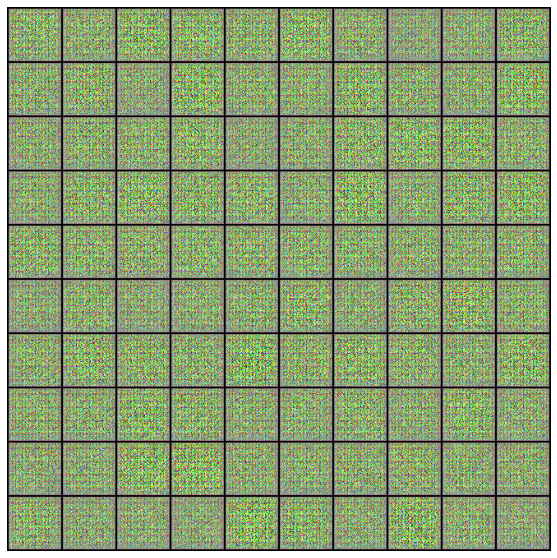

D(x): 0.03891    D(G(z)): 0.99843    D_kl: 0.28221    G(z): 0.99951    Z_rec: 1.28568    R_kl: 2.79708


D(x): 0.00990    D(G(z)): 0.99954    D_kl: 0.16608    G(z): 0.99977    Z_rec: 1.33976    R_kl: 2.75953


D(x): 0.00400    D(G(z)): 0.99979    D_kl: 0.05809    G(z): 0.99987    Z_rec: 1.45051    R_kl: 2.74580


In [ ]:
BATCH_SIZE = 128
Z_DIM = 500
R_DIM = 15
NDF = 64
NGF = 64
ITERATIONS = 100000
LOG_INTERVAL = 1
NUM_IMG = 1500
LAMBDA_G = 1
BETA_KL = 0.3
DATA_ROOT = "./celeba/"
device = "cuda:0" if torch.cuda.is_available else "cpu"
args_dict = {"BATCH_SIZE": BATCH_SIZE, "Z_DIM": Z_DIM, "R_DIM": R_DIM, "NDF": NDF, "NGF": NGF, "ITERATIONS": ITERATIONS, 
          "LAMBDA_G": LAMBDA_G, "BETA_KL": BETA_KL, "device": device, "DATA_ROOT": DATA_ROOT, "LOG_INTERVAL": LOG_INTERVAL,
          "NUM_IMG": NUM_IMG}
    
lr = 1e-5
IBGAN_model = IBGAN(NGF, NDF, Z_DIM, R_DIM, lr, lr, lr, lr)
IBGAN_model = IBGAN_model.to(device)

train(IBGAN_model, args_dict)